# Сборный проект "Интернет-магазин "Стримчик""

**Описание проекта:** Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Цель проекта:** Определение параметров, определяющих успешность игры. 

**Ход исследования:**
1. Подготовка данных - загрузка и изучение общей информации из предоставленных датасетов.
2. Предобработка данных - поиск пропущенных значений, дубликатов, корректировка типов данных, заполнение пропусков, замена названий столбцов (приведение к нижнему регистру), поиск аномальных значений.
3. Расширение набора данных - добавление нового столбца, такого как суммарные продажи во всех регионах.
4. Исследовательский анализ данных - изучение распределений продаж игр по годам, распределение продаж по платформам, определение прибыльных платформ, определение влияния оценок и отзывов на продажи, влияния жанра на продажи. Составление портрета пользователя каждого региона.
5. Проверка гипотез - проверка гипотез о том одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC, разные ли средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Общий вывод:** рекомендации по выбору потенциально популярного продукта и по составлению рекламных кампаний.

In [1]:
#импорт библиотек
import pandas as pd 
import numpy as np 
from scipy import stats as st 
from matplotlib import pyplot as plt 
import seaborn as sns

## Обзор данных

In [2]:
games = pd.read_csv('./games.csv') 
games.info() 
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


- Названия столбцов необходимо привести к нижнему регистру (кроме столбцов `NA_sales`, `EU_sales`, `JP_sales`).
- Тип данных в столбце `Year_of_Release` необходимо сменить на целочисленный.
- Тип данных в столбце `User_Score` необходимо сменить на числовой с плавающей точкой.


## Предобработка данных 

### Изменение регистра названий столбцов

In [3]:
#переименование столбцов датасета
games = games.rename(columns={'Name':'name', 
                              'Platform':'platform', 
                              'Year_of_Release':'year_of_release', 
                              'Genre':'genre', 
                              'Other_sales':'other_sales', 
                              'Critic_Score':'critic_score', 
                              'User_Score':'user_score', 
                              'Rating':'rating'})
games.columns #проверка изменения названий столбцов

Index(['name', 'platform', 'year_of_release', 'genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Поиск пропущенных значений

In [4]:
pd.DataFrame(round(games.isna().mean()*100,3)).style.background_gradient('coolwarm')

,0
name,0.012000
platform,0.000000
year_of_release,1.609000
genre,0.012000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
other_sales,0.000000
critic_score,51.319000
user_score,40.090000


- Пропущенные значения могли появиться из-за того, что эти параметры просто не внесли в данные о продажах конкретной игры или могли быть утеряны при выгрузке данных. Пропуски в столбцах с рейтингом могут быть связаны с тем, что игра только вышла и к тому моменту еще не выставили рейтинг.
- Пропущенные значения в столбце `name` можно удалить - их очень мало и нет никаких вариантов чем их можно заполнить. Так же и по тем же причинам можно поступить и с пропущенными данными в столбцах `year_of_release` и `genre`.
- Данные с пропущенными значениями в столбцах `critic_score`, `user_score` и `rating` удалять не будем, поскольку они могут содержать важные данные в других столбцах. Можно заполнить эти пропуски нулями, а в случае столбца `rating` - группу игр с рейтингом "неизвестный".

In [5]:
#обработка пропусков
games = games.dropna(subset=['name', 'year_of_release', 'genre']).reset_index(drop=True) #удаление строк с пропусками в столбцах name, year_of_release и genre
games['critic_score'] = games['critic_score'].fillna(0) #замена пропусков в столбце critic_score
games['user_score'] = games['user_score'].fillna(0) #замена пропусков в столбце user_score
games['rating'] = games['rating'].fillna('неизвестный') #замена пропусков в столбце rating
games.isna().sum() #проверка на удаление строк с пропусками

name               0
platform           0
year_of_release    0
genre              0
NA_sales           0
EU_sales           0
JP_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Все пропуски были обработаны.

### Поиск и удаление дубликатов

In [6]:
games.duplicated().sum() #поиск дубликатов

0

Явных дубликатов не обнаружено.

### Поиск аномальных значений и неявных дубликатов

In [7]:
games['platform'].sort_values().unique() #поиск уникальных значений в столбце platform

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Неявных дубликатов нет.

In [8]:
games['genre'].sort_values().unique() #поиск уникальных значений в столбце genre

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

Неявных дубликатов нет.

In [9]:
games[games[['name', 'platform','year_of_release']].duplicated(keep=False)] #поиск неявных дубликатов

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
600,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
15969,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


В данных встречается строчки, в которых встречается одна и та же игра с одинаковыми оценками, но с разными данными по продажам. Оставим строчку, в которой есть данные о продажах.

In [10]:
games = games.drop(index=15969).reset_index(drop=True) #удаление неявного дубликата

In [11]:
games['critic_score'].sort_values().unique() #поиск уникальных значений в столбце critic_score

array([ 0., 13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
       82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94.,
       95., 96., 97., 98.])

Все значения соотвествуют действительности (должны быть от 0 до 100). Необходимо сменить тип данных на целочисленный.

In [12]:
games['user_score'].unique() #поиск уникальных значений столбца user_score

array(['8', 0, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Есть странное значение tbd неизвестного происхождения. Заменим его на 0, как до этого пропуски.

In [13]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = 0 #замена значений tbd на нулевые
games['user_score'].unique() #проверка замены

array(['8', 0, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [14]:
games['rating'].sort_values().unique() #поиск уникальных значений столбца rating

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', 'неизвестный'],
      dtype=object)

Категория рейтинга K-A использовалась до 1998 года, а потом была заменена на категорию Е. Поэтому необходимо эти значения заменить на категорию Е.

In [15]:
games.loc[games['rating'] == 'K-A', 'rating'] = 'E' #замена категории K-A на Е
games['rating'].sort_values().unique() #проверка замены

array(['AO', 'E', 'E10+', 'EC', 'M', 'RP', 'T', 'неизвестный'],
      dtype=object)

### Изменение типов данных в столбцах 

In [16]:
games[['year_of_release', 'critic_score']] = games[['year_of_release', 'critic_score']].astype('int') #изменение типа данных столбца year_of_release и critic_score
games['user_score'] = games['user_score'].astype('float') #изменение типа данных столбца user_score
games.info() #вывод общей информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   NA_sales         16443 non-null  float64
 5   EU_sales         16443 non-null  float64
 6   JP_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


Теперь все данные нужного типа и пропусков в данных нет.

### Создание столбца с суммарными продажами

In [17]:
games['total_sales'] = games[['NA_sales','EU_sales','JP_sales', 'other_sales']].sum(axis = 1) #создание нового столбца
games.head() #проверка создания столбца

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,неизвестный,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,неизвестный,31.38


В данном разделе были выполнены:
* поиск и замена пропусков;
* поиск явных дубликатов;
* поиск и замена неявных дубликатов;
* поиск и замена аномальных значений;
* изменение названия столбцов;
* изменение типов данных в некоторых столбцах;
* создание нового столбца с суммарными продажами.

## Исследовательский анализ данных

### Количество продаж по годам

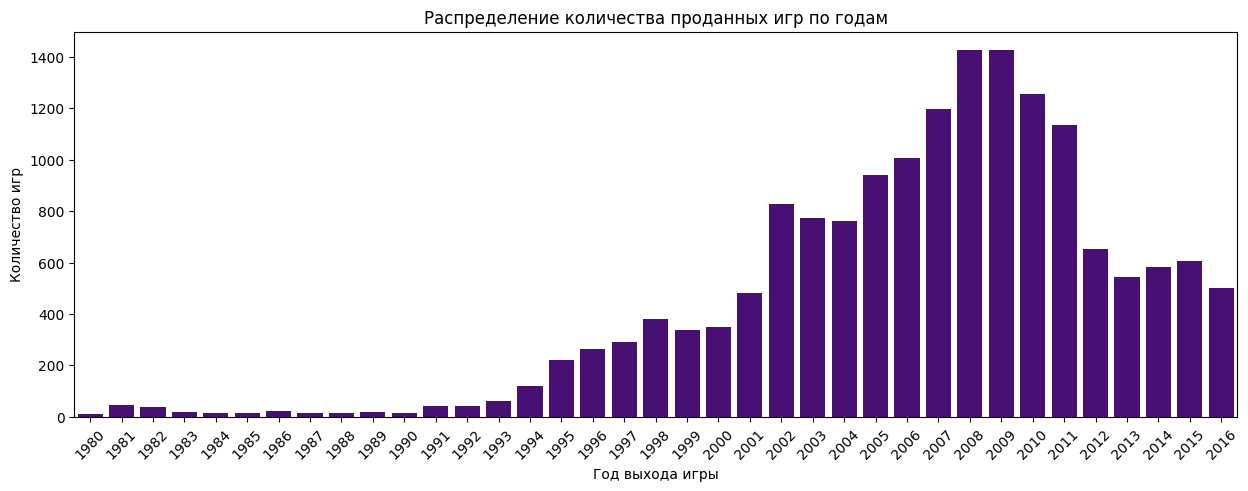

In [18]:
plt.figure(figsize=(15,5))
plt.title('Распределение количества проданных игр по годам')
sns.barplot(games.groupby('year_of_release')['name'].count(), color='Indigo')
plt.xlabel('Год выхода игры')
plt.ylabel('Количество игр')
plt.xticks(rotation=45);

До 1991 года игр продавалось очень мало по сравнению со следующими годами. Для выявления закономерностей успешности игры это время (с 1980 по 1991) не особо интересно. После 2008-2009 года наблюдается спад в продаж игр (Возможно из-за мирового кризиса?). 

### Количество продаж по платформам

Выберем 3 платформы с наибольшими суммарными продажами и посмотрим как менялось распределение продаж на этих платформах по годам.

In [19]:
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(3) #выбор платформ с наибольшими суммарными продажами

platform
PS2     1233.56
X360     961.24
PS3      931.33
Name: total_sales, dtype: float64

Платформами с наибольшими суммарными продажами являются *PS2*, *X360* и *PS3*. Посмотрим как менялось распределение продаж по годам.

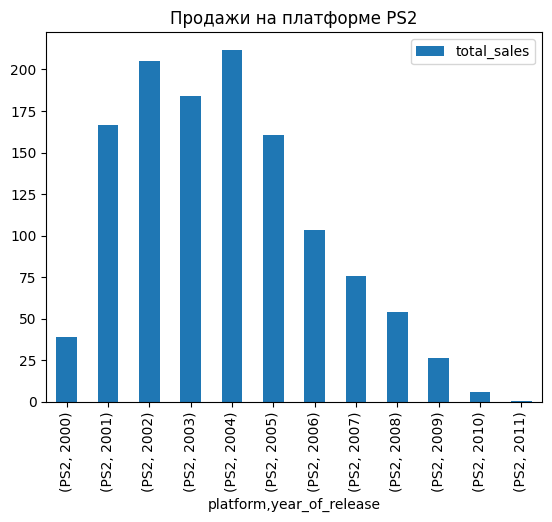

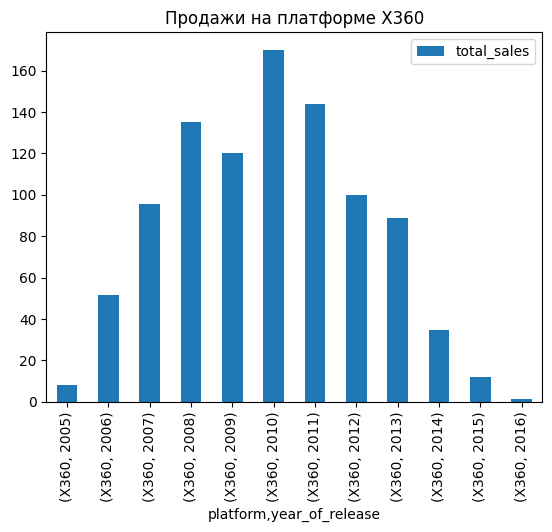

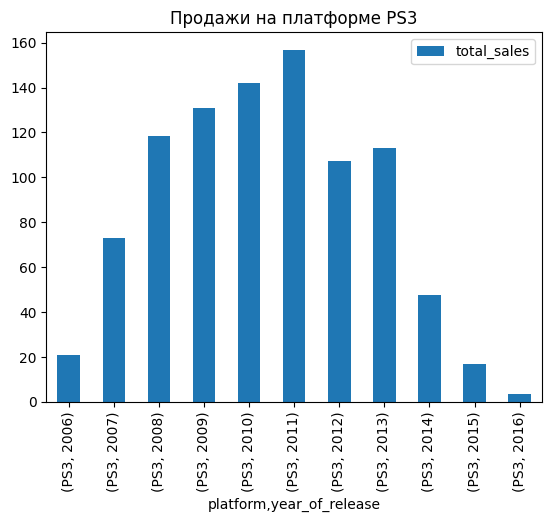

In [20]:
#группировка продаж по платформам и годам
games_platform = games.groupby(['platform', 'year_of_release']).agg({'total_sales':'sum'})
#Построение гистограмм распределения для наиболее прибыльных платформ
platform_bigger_sales = ['PS2', 'X360', 'PS3']

for name in platform_bigger_sales:
    games_platform.query('platform == @name').plot(kind='bar', title=f'Продажи на платформе {name}')

Видим, что платформа PS2 начала терять свою популярность в 2006 году, однако в это время как раз начали набирать свою популярность платформы X360 и PS3. В целом, время "жизни" платформы составляет **12 лет**. 

Для определения наиболее перспективной на 2017 год платформы нужно рассмотреть как меняются продажи игр по платформам за последние 5 лет (с 2012 по 2016 год). 

In [21]:
#создание датасета с играми, проданными с 2012 по 2016 год
games_actual = games.query('year_of_release > 2011') 

In [22]:
#сортировка платформ по продажам с 2012 по 2016 год
games_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False) 

platform
PS4     314.14
PS3     288.78
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64

Наиболее прибыльными в период 2012-2016 гг были платформы *PS4*, *PS3*, *X360* и *3DS*. 

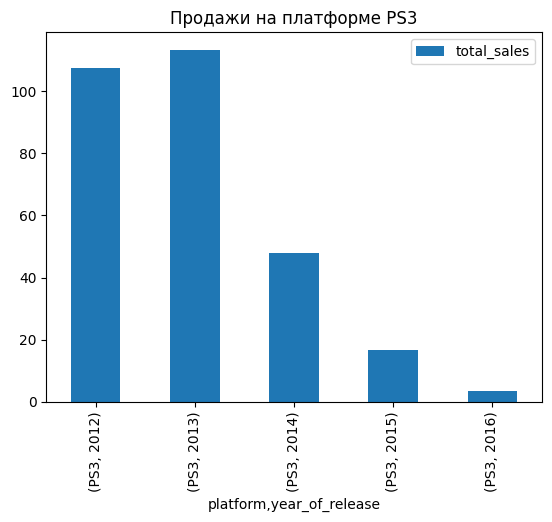

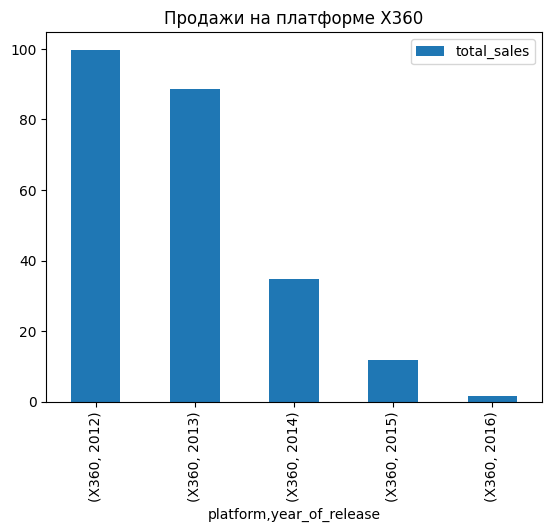

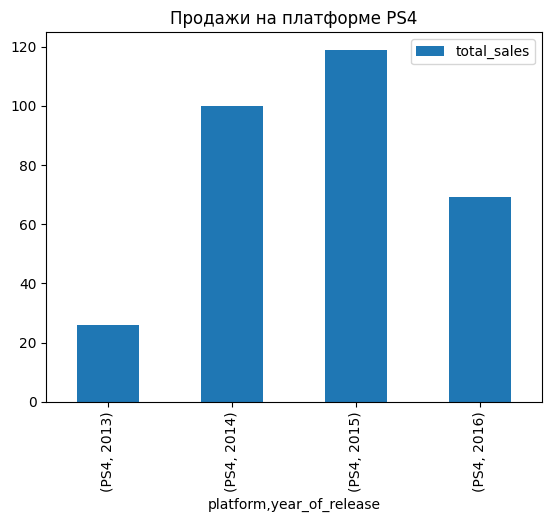

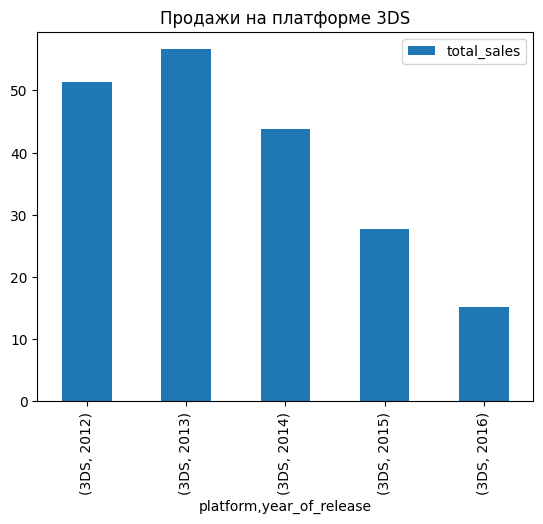

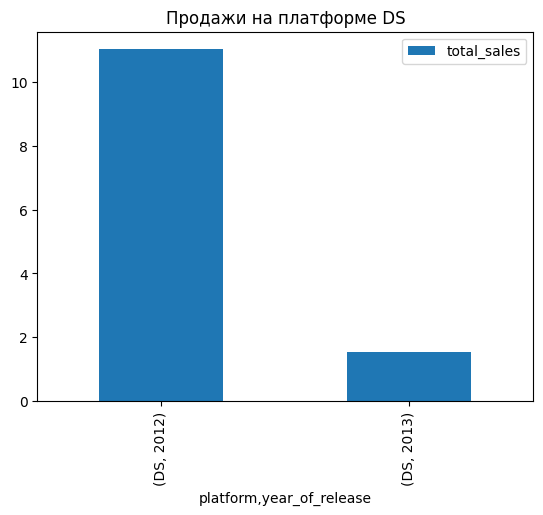

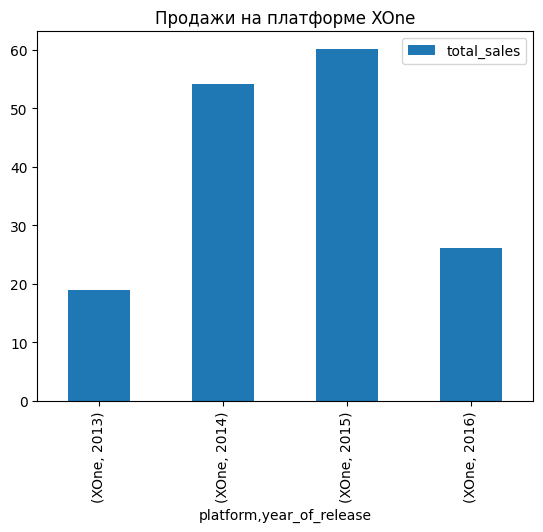

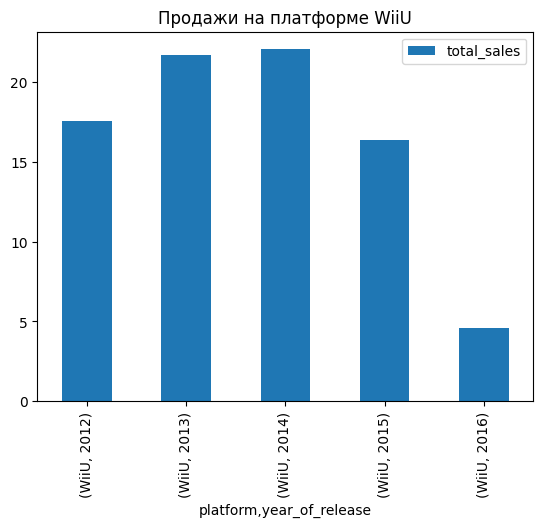

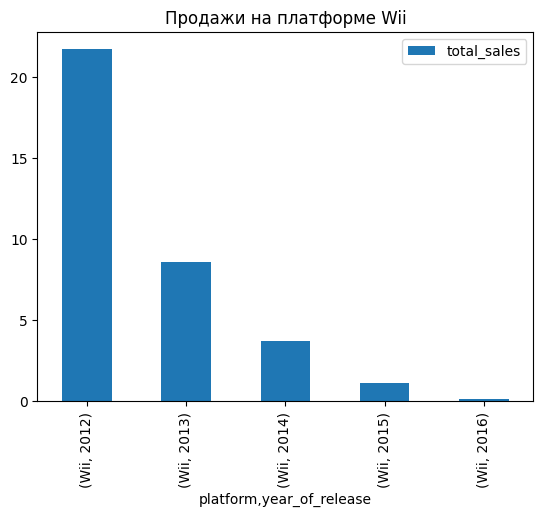

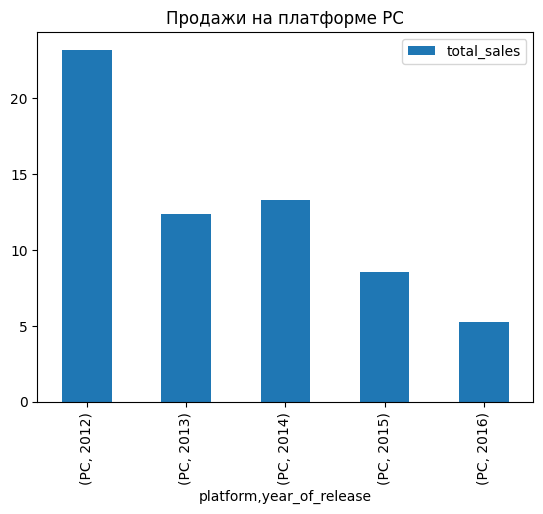

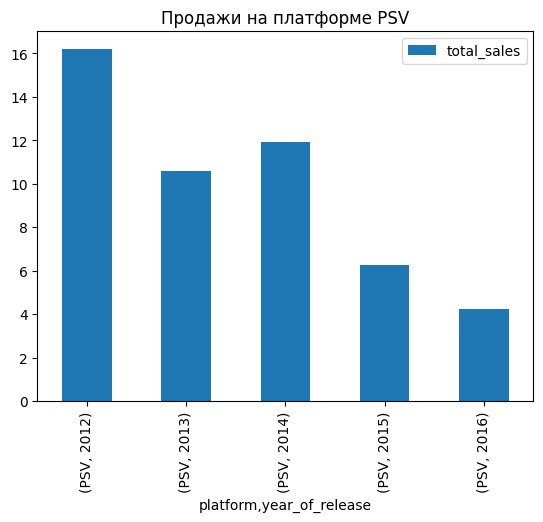

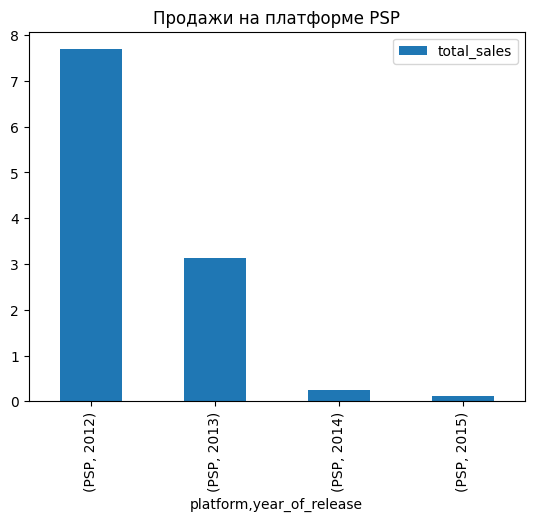

In [23]:
#группировка продаж по платформам и годам
games_5_platform = games_actual.groupby(['platform', 'year_of_release']).agg({'total_sales':'sum'})

platforms = games_actual['platform'].unique() #список платформ, на которых осуществлялись продажи с 2012 по 2016 года

for name in platforms:
    games_5_platform.query('platform == @name').plot(kind='bar', title=f'Продажи на платформе {name}');#вывод гистограмм распределения продаж для каждой платформы

Со скепсисом надо отнестись к данным по продажам за 2016 год, поскольку эти данные могут быть не полными.
На основании приведенных гистограмм распределения продаж на разных платформах с 2012 по 2016 год можно выделить несколько групп платформ:
- **снижение продаж**: PS3, X360, 3DS, DS, Wii, PC, PSV, PSP
- **рост продаж**: PS4, XOne, WiiU.
Вторую группу стоит рассмотреть как наиболее перспективные платформы.

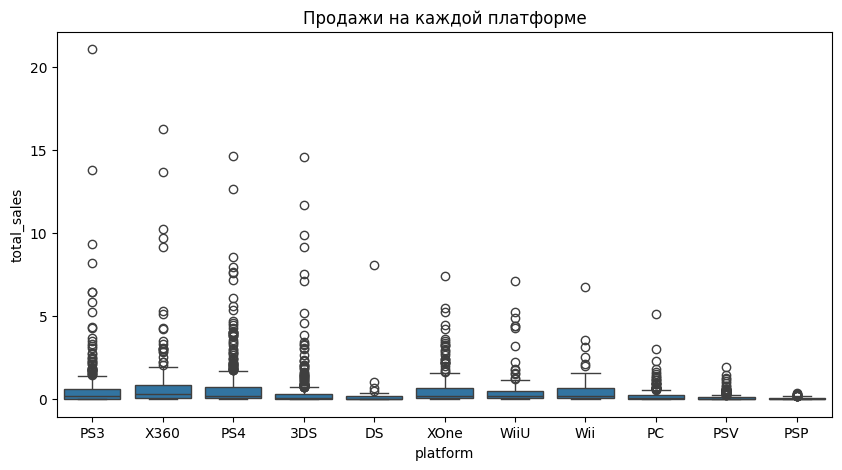

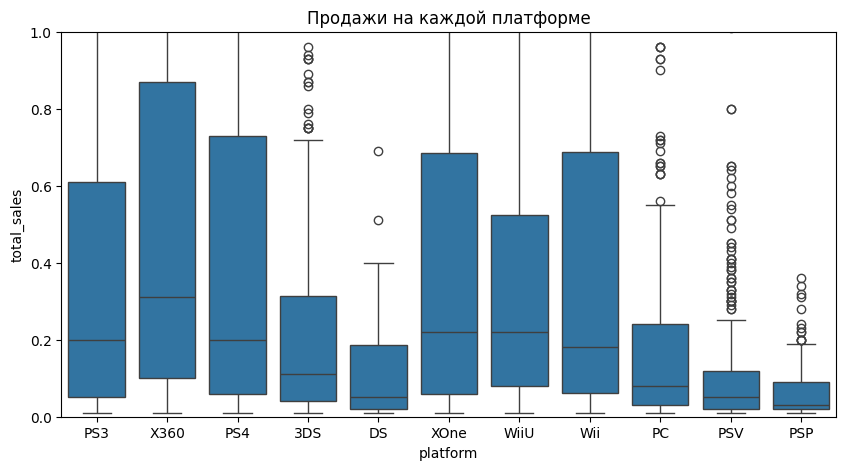

In [24]:
#построение "ящика с усами" для продаж по платформам
plt.figure(figsize=(10,5))
sns.boxplot(x='platform', y='total_sales', data=games_actual, notch=False)
plt.title('Продажи на каждой платформе')
plt.show()

#тот же график, но в меньшем диапазоне значений, чтобы лучше его разглядеть
plt.figure(figsize=(10,5))
sns.boxplot(x='platform', y='total_sales', data=games_actual, notch=False)
plt.title('Продажи на каждой платформе')
plt.ylim(0, 1)
plt.show()

У всех платформ встречаются игры с аномально большими продажами. Среднее (медианное) количество продаж находится в диапазоне от 0 до 0.3 миллионов копий. 

### Влияние оценок критиков и пользователей на продажи

Для определения влияния оценок критиков и пользователей выберем 6 наиболее прибыльных платформ за 2012-2016 годы - *PS4*, *PS3*, *X360*, *3DS*, *XOne*, *WiiU*, среди которых находятся и наиболее перспективные платформы - *PS4*, *XOne*, *WiiU*.

#### Влияние оценк критиков 

Коэффициент корреляции Пирсона для платформы PS4: 0.407
Коэффициент корреляции Пирсона для платформы PS3: 0.334
Коэффициент корреляции Пирсона для платформы X360: 0.361
Коэффициент корреляции Пирсона для платформы 3DS: 0.321
Коэффициент корреляции Пирсона для платформы XOne: 0.417
Коэффициент корреляции Пирсона для платформы WiiU: 0.348


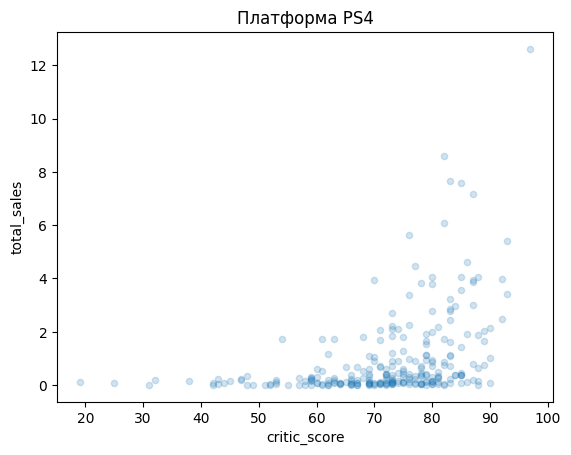

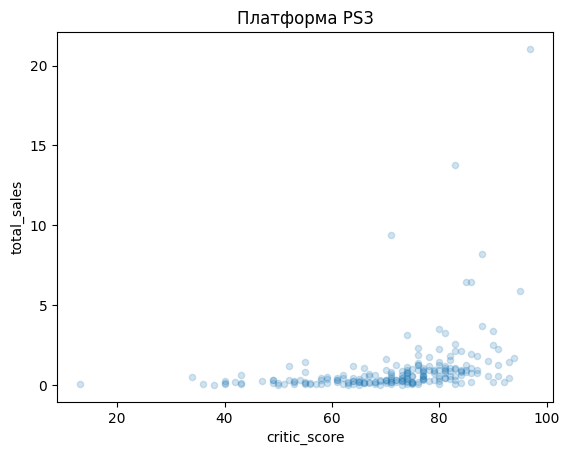

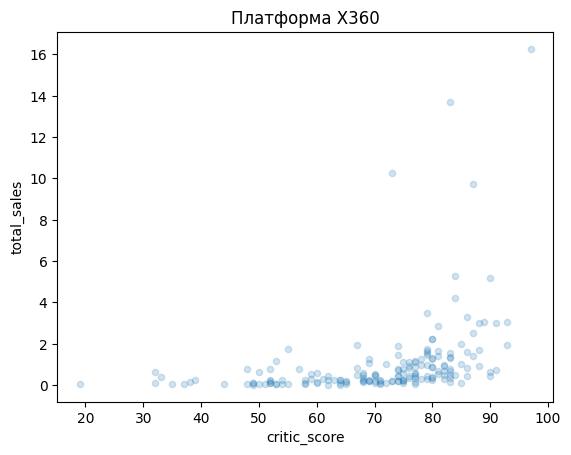

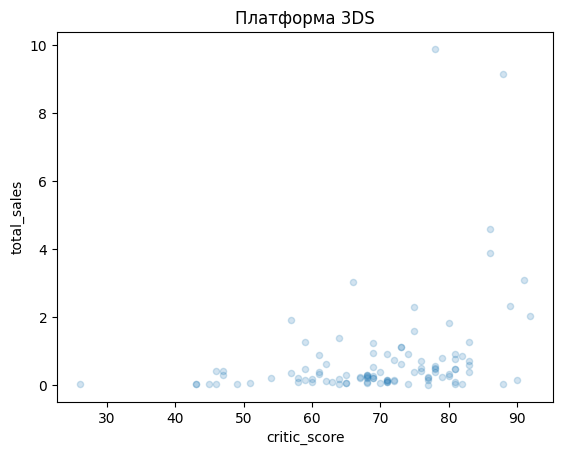

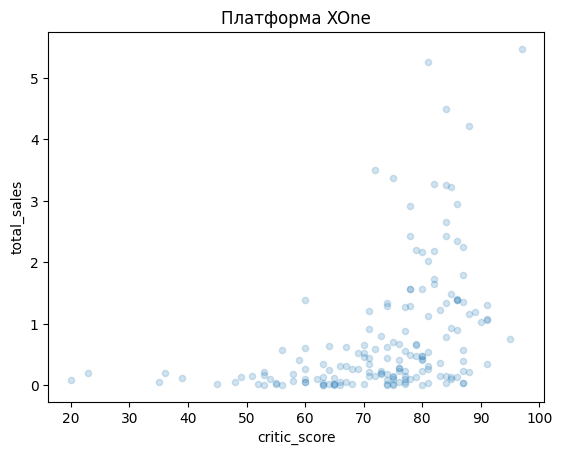

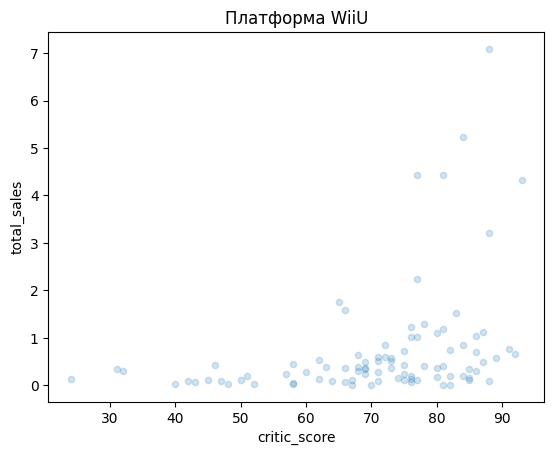

In [25]:
platform = ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU'] #список наиболее прибыльных платформ за 2012-2016 годы

#построение диаграмм рассеивания для каждой платформы и расчет коэффициента корреляции Пирсона
for name in platform:
    games_actual.query('critic_score > 0 and platform == @name').plot(x='critic_score', 
                                                                      y='total_sales', 
                                                                      kind='scatter', 
                                                                      alpha=0.2, 
                                                                      title=f'Платформа {name}')
    print(f'Коэффициент корреляции Пирсона для платформы {name}:', round(games_actual.query('critic_score > 0 and platform == @name')['total_sales'].corr(games_actual.query('critic_score > 0 and platform == @name')['critic_score']), 3))

Для всех выбранных платформ наблюдается слабая положительная взаимосвязь между продажами и оценками критиков.

#### Влияние оценок пользователей

Коэффициент корреляции Пирсона для платформы PS4: -0.032
Коэффициент корреляции Пирсона для платформы PS3: -0.006
Коэффициент корреляции Пирсона для платформы X360: 0.006
Коэффициент корреляции Пирсона для платформы 3DS: 0.198
Коэффициент корреляции Пирсона для платформы XOne: -0.069
Коэффициент корреляции Пирсона для платформы WiiU: 0.4


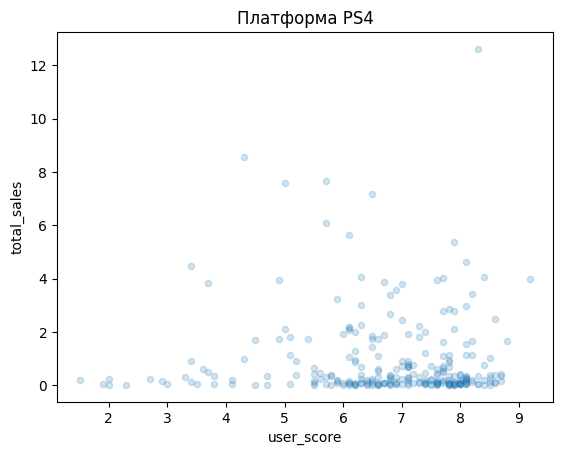

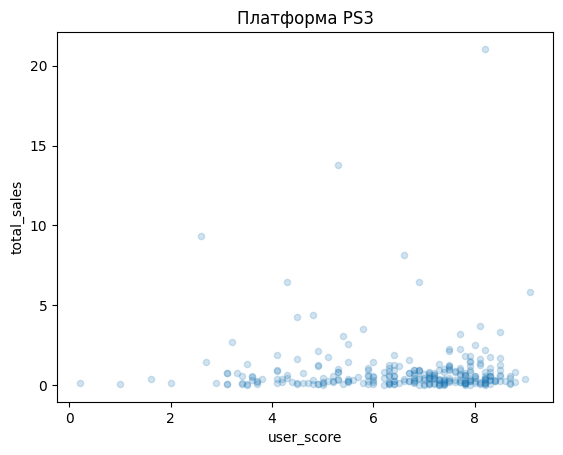

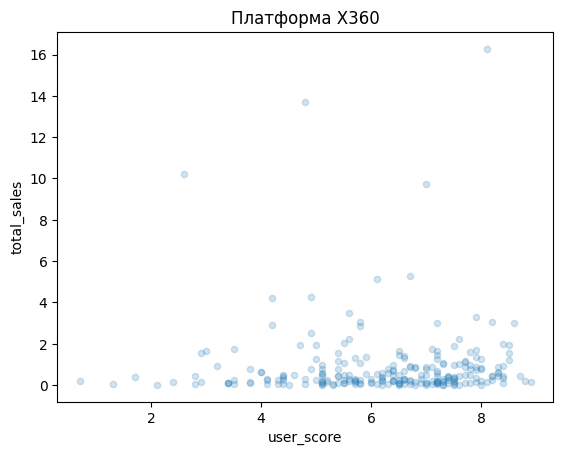

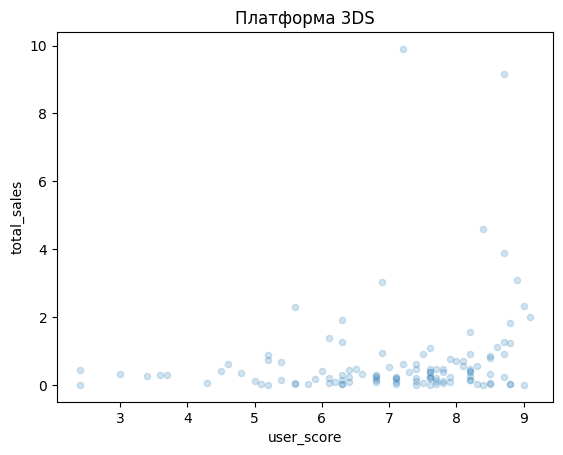

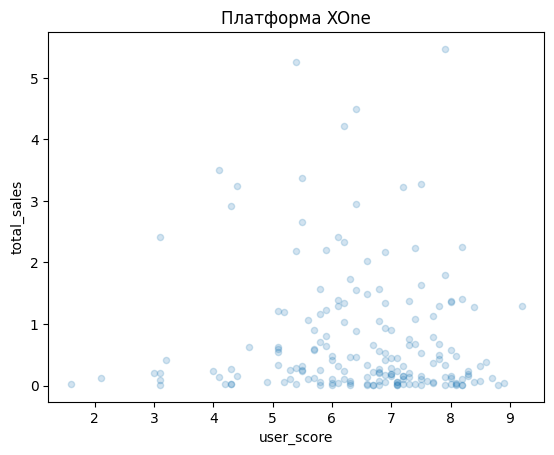

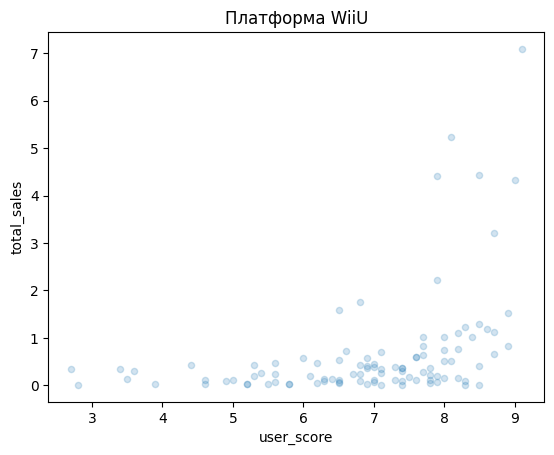

In [26]:
#построение диаграмм рассеивания для каждой платформы и расчет коэффициента корреляции Пирсона
for name in platform:
    games_actual.query('user_score > 0 and platform == @name').plot(x='user_score', 
                                                                      y='total_sales', 
                                                                      kind='scatter', 
                                                                      alpha=0.2, 
                                                                      title=f'Платформа {name}')
    print(f'Коэффициент корреляции Пирсона для платформы {name}:', round(games_actual.query('user_score > 0 and platform == @name')['total_sales'].corr(games_actual.query('user_score > 0 and platform == @name')['user_score']), 3))

Для двух платформ - 3DS и WiiU - наблюдается слабая положительная корреляция между продажами и оценками пользователей. Для остальных платформ корреляции нет.

### Влияние жанра игр на продажи

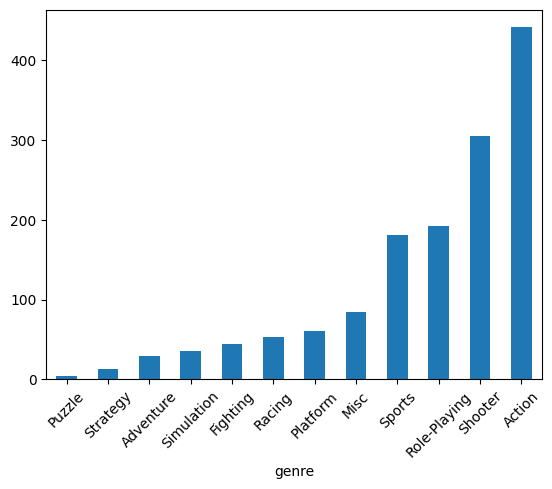

In [27]:
games_actual.groupby('genre')['total_sales'].sum().sort_values().plot(kind='bar', rot=45);

Наиболее продаваемые жанр игр - *Action* и *Shooter*, наименее продаваемый - *Strategy* и *Puzzle*. Кажется, чем проще жанр (простой набор команд, не требует больших умственных затрат, простые задания), тем лучше она продается.

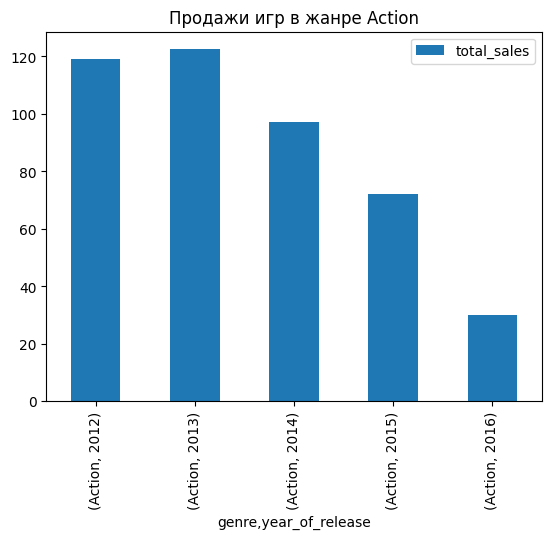

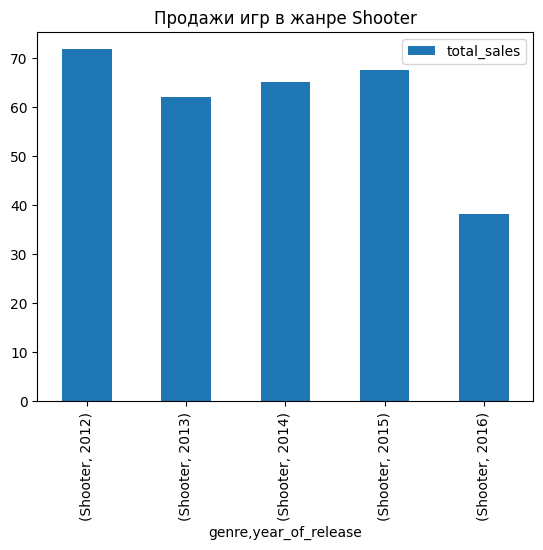

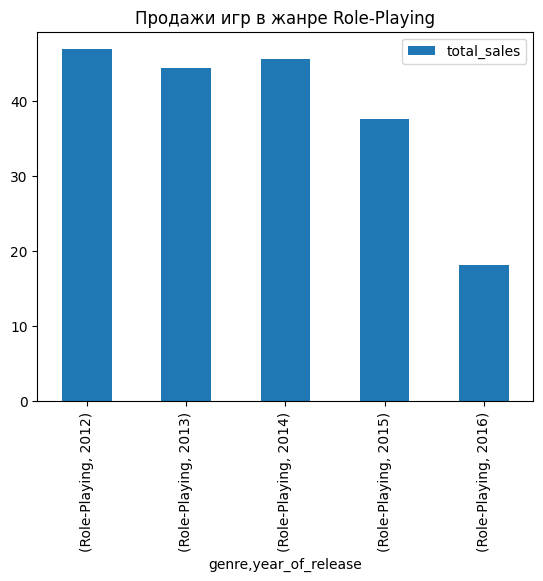

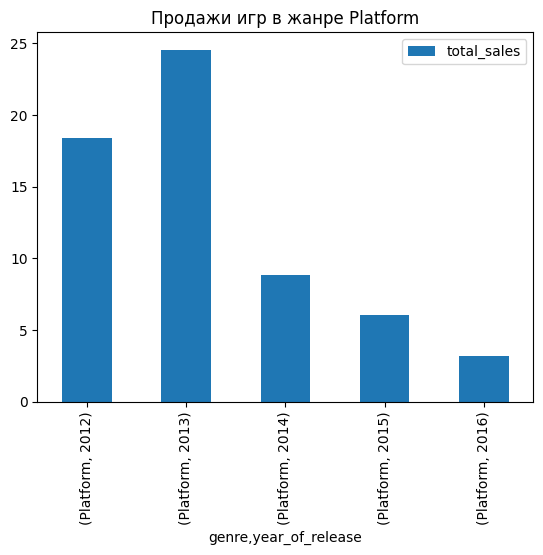

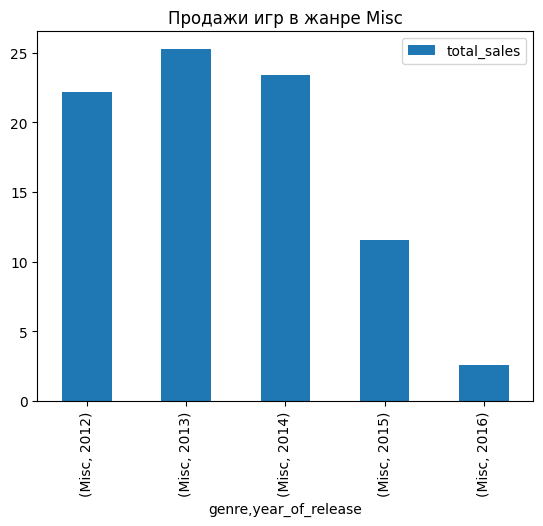

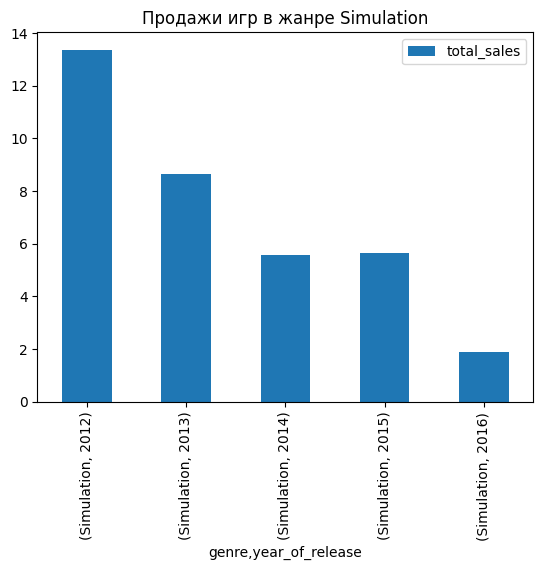

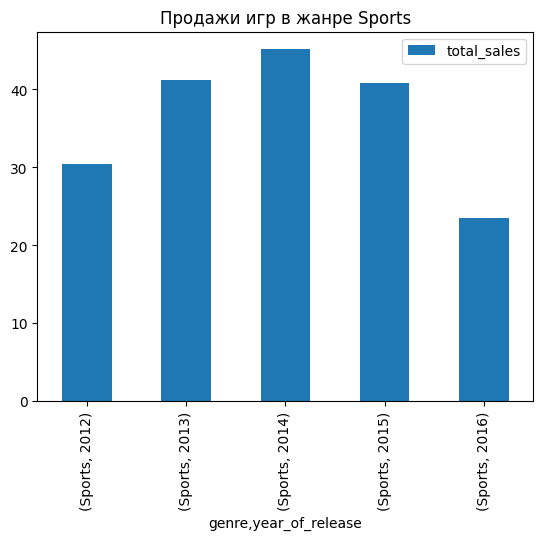

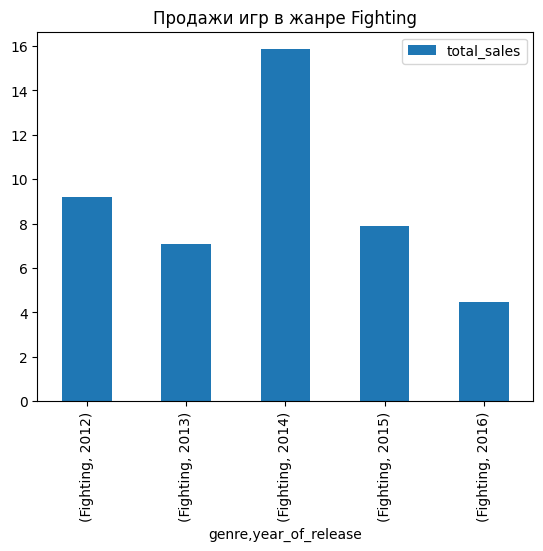

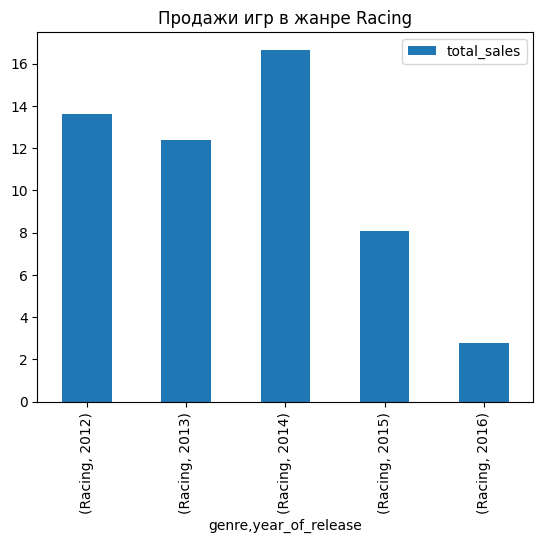

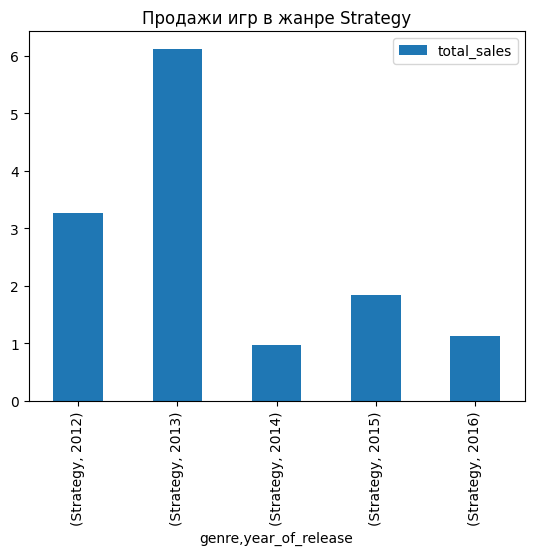

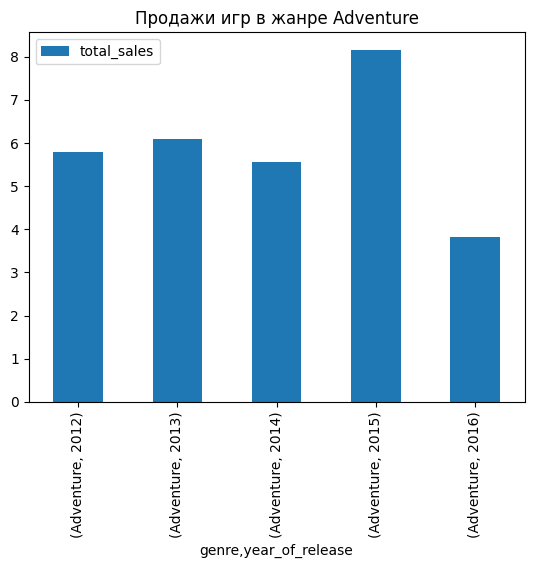

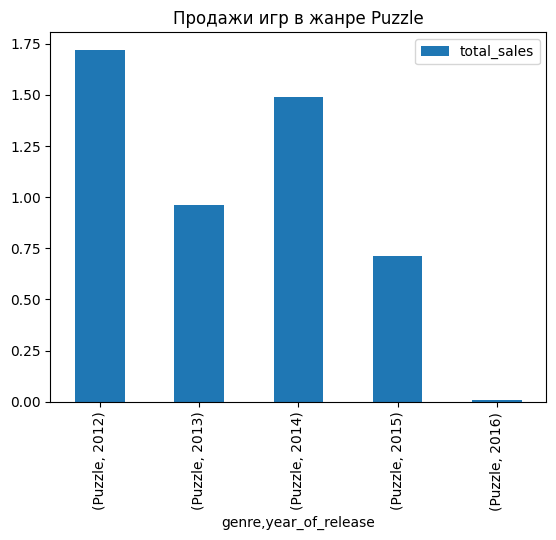

In [28]:
#группировка продаж по жанрам и годам
games_genre = games_actual.groupby(['genre', 'year_of_release']).agg({'total_sales':'sum'})

platforms = games_actual['genre'].unique() #список жанров

#вывод гистограмм распределения продаж для каждого жанра игр
for name in platforms: 
    games_genre.query('genre == @name').plot(kind='bar', 
                                             title=f'Продажи игр в жанре {name}');

Из полученных гистограмм распределения продаж игр определенного жанра по годам мы видим, что такие жанры как *action, role-playing, sports, fighting, shooter* и *adventure* остаются популярными (их продажи практически не изменились в течение этого времени). Популярность таких жанров как *racing, strategy* понемногу снижается, в то время как продажи игр жанров *platform, misc, simulation и puzzle* сильно просели.

Для выбора наиболее перспективных платформ рассмотрим среднее значение продаж на каждой платформе.

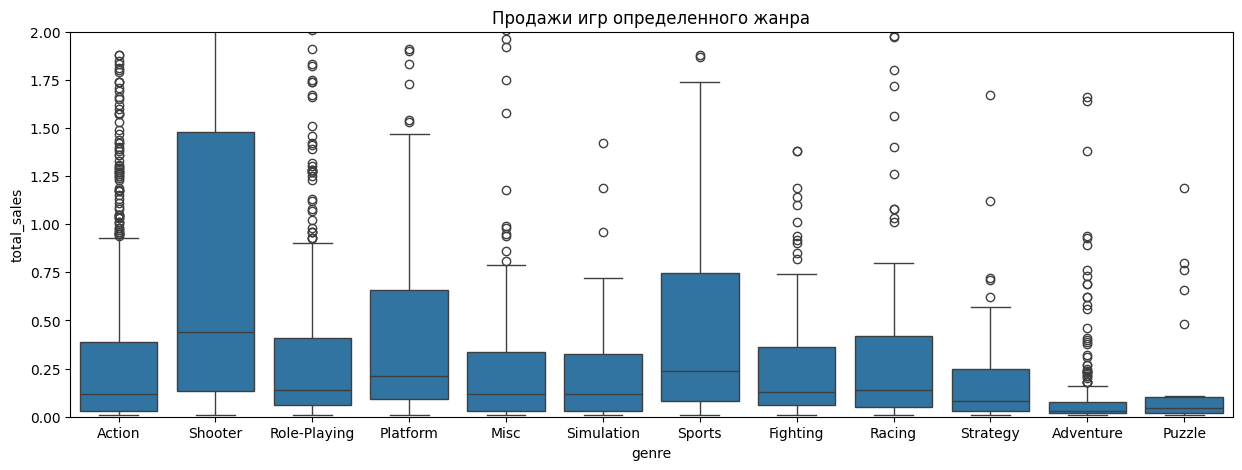

In [29]:
#построение диаграмм размаха продаж для каждого жанра 
plt.figure(figsize=(15,5))
sns.boxplot(x='genre', y='total_sales', data=games_actual, notch=False)
plt.title('Продажи игр определенного жанра')
plt.ylim(0, 2)
plt.show()

Наибольшие средние (медианные) продажи наблюдаются у игр жанра *shooter, sports и platform*.

Поэтому, в 2017 году стоит нацелится на продажи игр таких жанров как **sports и shooter**. 

### Портрет пользователя различных регионов

В наборе данных присутствует информация о продажах в разных регионах - *Северная Америка* (столбец `NA_sales`), Европа (столбец `EU_sales`) и Япония (столбец `JP_sales`). Составим портрет пользователя для каждого региона - 5 наиболее популярных платформ и жанров и как влияет рейтинг игры ESRB на продажи игр.

#### Популярные платформы

In [30]:
#группировка датасета по платформам и подсчет суммарных продаж в каждом регионе
games_NA_platform = games_actual.groupby('platform')['NA_sales'].sum().sort_values(ascending=False).head()
games_EU_platform = games_actual.groupby('platform')['EU_sales'].sum().sort_values(ascending=False).head()
games_JP_platform = games_actual.groupby('platform')['JP_sales'].sum().sort_values(ascending=False).head()

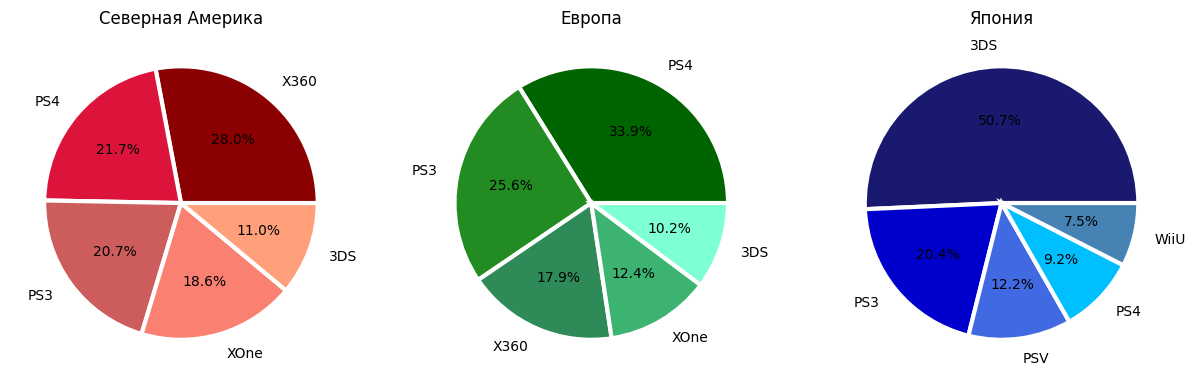

In [31]:
#построение круговых диаграмм с популярными платформами для каждого региона
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title('Северная Америка')
plt.pie(x=games_NA_platform, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_NA_platform.index, 
        colors=['DarkRed', 'Crimson', 'IndianRed', 'Salmon', 'LightSalmon']);

plt.subplot(1, 3, 2)
plt.title('Европа')
plt.pie(x=games_EU_platform, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_EU_platform.index, 
        colors=['DarkGreen', 'ForestGreen', 'SeaGreen', 'MediumSeaGreen', 'Aquamarine']);

plt.subplot(1, 3, 3)
plt.title('Япония')
plt.pie(x=games_JP_platform, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_JP_platform.index, 
        colors=['MidnightBlue', 'MediumBlue', 'RoyalBlue', 'DeepSkyBlue', 'SteelBlue']);

В Америке наиболее популярной платформой является Xbox 360, в Европе - PS4, а в Японии - 3DS. 

Есть предположение, что в Америке Xbox 360 стала популярной из-за того, что эту платформу производит компания Microsoft, которая является американской компанией. Поэтому эта платформа была хорошо раскручена на родине. 

В случае 3DS - она представляет собой портативную консоль. Поэтому для трудоголиков японцев это самый отличный вариант - можно на работе сделать небольшой перерыв на игру и не сойти с ума от переработок :)

Возможно, популярность платформы также связана с тем, какие жанры игр выходят на этих платформах. Проверим это.

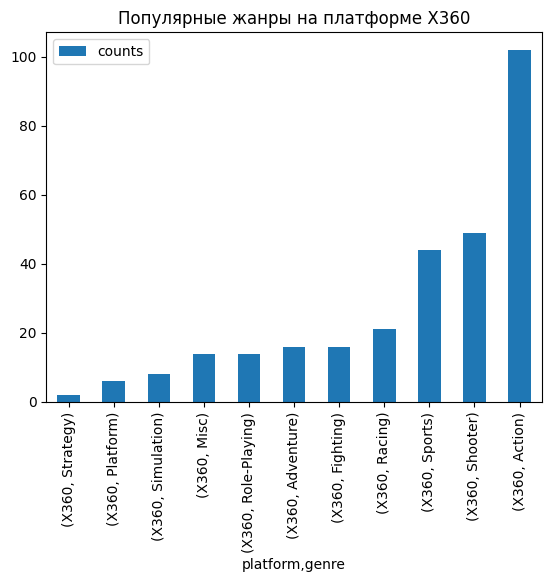

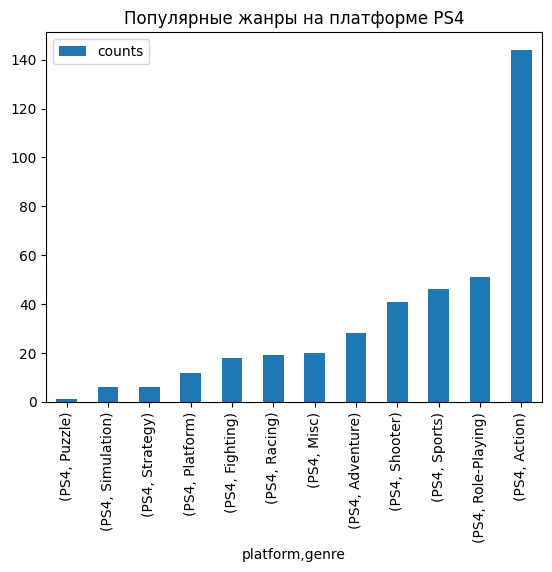

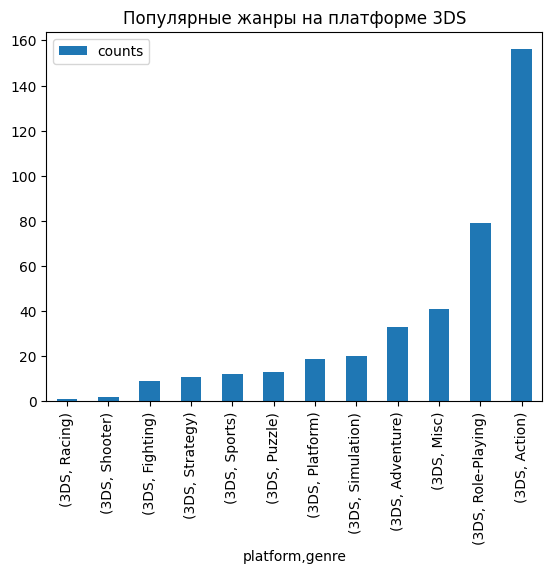

In [32]:
#группировка по платформам и жанрам
games_platform_genre = games_actual.groupby(['platform', 'genre']).agg({'genre':'count'})
games_platform_genre.columns = games_platform_genre.columns.str.replace('genre', 'counts') #замена названия столбца

platform_genre = ['X360', 'PS4', '3DS'] #наиболее популярные платформы в каждом регионе

#построение столбчатых диаграмм
for name in platform_genre:
    games_platform_genre.query('platform == @name').sort_values(by='counts').plot(kind='bar', 
                                                                                  title=f'Популярные жанры на платформе {name}', )

На платформах *X360* и *PS4* в основном выпускаются экшн, шутеры и спортивные игры, которые американцы и европейцы видимо очень любят. А на 3DS довольно популярными являются жанры *Action*, *Role-Playing*, *Misc* (разнообразные игры), *Simulation* и даже *Puzzle* - само то для отвлечения на работе:)

#### Популярные жанры

In [33]:
#группировка датасета по жанрам и подсчет суммарных продаж в каждом регионе
games_NA_genre = games_actual.groupby('genre')['NA_sales'].sum().sort_values(ascending=False).head()
games_EU_genre = games_actual.groupby('genre')['EU_sales'].sum().sort_values(ascending=False).head()
games_JP_genre = games_actual.groupby('genre')['JP_sales'].sum().sort_values(ascending=False).head()

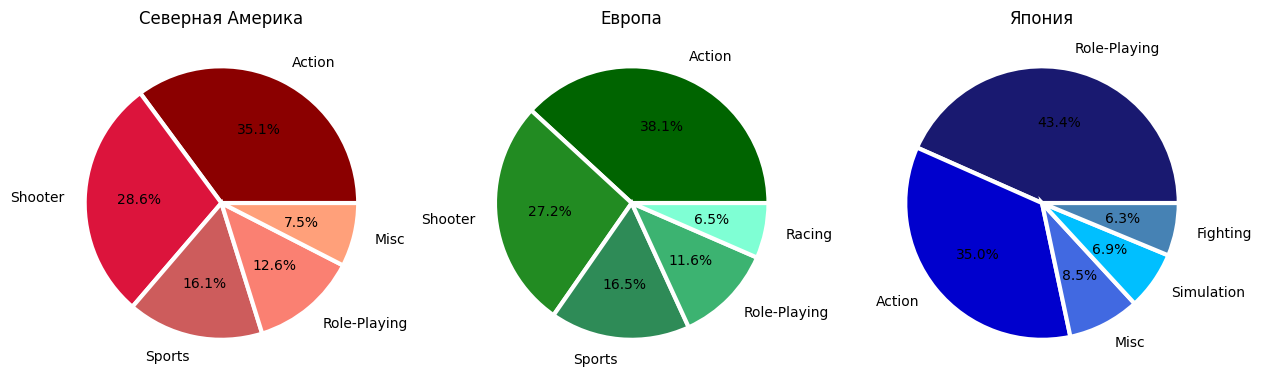

In [34]:
#построение круговых диаграмм с популярными жанрами для каждого региона
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title('Северная Америка')
plt.pie(x=games_NA_genre, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_NA_genre.index, 
        colors=['DarkRed', 'Crimson', 'IndianRed', 'Salmon', 'LightSalmon']);

plt.subplot(1, 3, 2)
plt.title('Европа')
plt.pie(x=games_EU_genre, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_EU_genre.index, 
        colors=['DarkGreen', 'ForestGreen', 'SeaGreen', 'MediumSeaGreen', 'Aquamarine']);

plt.subplot(1, 3, 3)
plt.title('Япония')
plt.pie(x=games_JP_genre, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_JP_genre.index, 
        colors=['MidnightBlue', 'MediumBlue', 'RoyalBlue', 'DeepSkyBlue', 'SteelBlue']);

Наиболее популярными играми в Америке и Европе являются *экшн игры* и *стрелялки*, а также *спортивные*, что в целом совпадает с тем, какие наиболее популярные жанры игры мы наблюдали ранее на самых популярных платформах в Америке и Европе.

В Японии же наиболее популярным жанром является *role-playing*. Возможно это связано с тем, что можно сказать, что исторически жанр компьютерных ролевых игр зародился именно в Японии. Может быть это связано с тем, что такие игры обычно более размеренные, в них нужно неспешно проходить квесты, общаться с персонажами - всё что так нужно уставшему на работе японцу)

#### Влияние рейтинга ESRB на продажи в отдельном регионе

In [35]:
games_NA_rating = games_actual.groupby('rating')['NA_sales'].sum().sort_values()
games_EU_rating = games_actual.groupby('rating')['EU_sales'].sum().sort_values()
games_JP_rating = games_actual.groupby('rating')['JP_sales'].sum().sort_values()

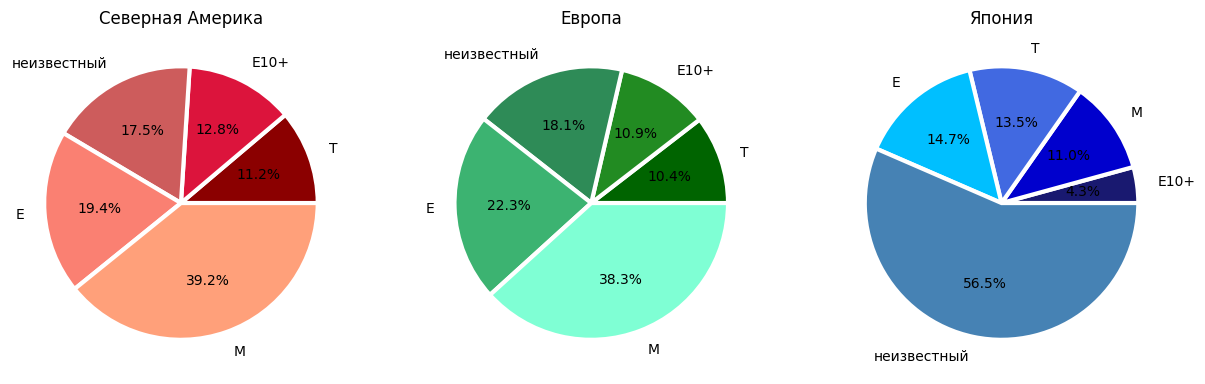

In [36]:
#построение круговых диаграмм с популярными жанрами для каждого региона
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title('Северная Америка')
plt.pie(x=games_NA_rating, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_NA_rating.index, 
        colors=['DarkRed', 'Crimson', 'IndianRed', 'Salmon', 'LightSalmon']);

plt.subplot(1, 3, 2)
plt.title('Европа')
plt.pie(x=games_EU_rating, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_EU_rating.index, 
        colors=['DarkGreen', 'ForestGreen', 'SeaGreen', 'MediumSeaGreen', 'Aquamarine']);

plt.subplot(1, 3, 3)
plt.title('Япония')
plt.pie(x=games_JP_rating, 
        labeldistance=1.15, 
        wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
        autopct='%1.1f%%', 
        labels=games_JP_rating.index, 
        colors=['MidnightBlue', 'MediumBlue', 'RoyalBlue', 'DeepSkyBlue', 'SteelBlue']);

Наиболее продаваемыми в Америке и Европе являются игры с рейтингом *M* - пользователям старше 17 лет - видимо это позволяет играть в жестокие игры, но не такие жестокие как с рейтингом AO. В целом распределение продаж игр в соответсвии с рейтингом ESRB совпадает для этих регионов. Это в целом соотносится с тем, что в этих регионах популярны практически одни и те же платформы и жанры игр.

В случае Японии наиболее популярными являются игры, у которых рейтинг не известен. Это могут быть совсем молодые игры, которым еще не проставили рейтинг. Так что по-видимому японцы очень любят новинки.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Проверим, являются ли средние пользовательские рейтинги платформ Xbox One и PC одинаковыми. Для этого сформулируем следующие гипотезы:

- Нулевая гипотеза Н0: средние пользовательские рейтинги платформ Xbox One и PC равны.
- Альтернативная гипотеза Н1: средние пользовательские рейтинги платформ Xbox One и PC не равны (двусторонняя гипотеза).

Поскольку мы будем сравнивать два средних значения двух выборок из двух независимых генеральных совокупностей, то будем использовать метод `st.ttest_ind(array1, array2)`

In [37]:
#проверка гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC
games_XOne = games_actual.query('platform == "XOne" and user_score != 0')
games_PC = games_actual.query('platform == "PC" and user_score != 0')
alpha = 0.05 #уровень значимости 

results = st.ttest_ind(games_XOne['user_score'], games_PC['user_score']) #расчет p_value

print('Средний пользовательский рейтинг платформы XOne:', round(games_XOne['user_score'].mean(), 2))
print('Средний пользовательский рейтинг платформы РС:', round(games_PC['user_score'].mean(), 2))
print('p-значение:', round(results.pvalue, 5))

if results.pvalue < alpha: #проверка p_value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг платформы XOne: 6.52
Средний пользовательский рейтинг платформы РС: 6.43
p-значение: 0.55351
Не получилось отвергнуть нулевую гипотезу


По результатам статистического теста мы не отвергаем нулевую гипотезу. Так что можно предположить, что средние пользовательские рейтинги платформ Xbox One и PC не различаются.

### Средние пользовательские рейтинги жанров Action и Sports разные

Проверим, являются ли средние пользовательские рейтинги игр жанров Action и Sports разными. Для этого сформулируем следующие гипотезы:

- Нулевая гипотеза Н0: средние пользовательские рейтинги игр жанров Action и Sports равны.
- Альтернативная гипотеза Н1: средние пользовательские рейтинги игр жанров Action и Sports не равны (двусторонняя гипотеза).

Поскольку мы будем сравнивать два средних значения двух выборок из двух независимых генеральных совокупностей, то будем использовать метод `st.ttest_ind(array1, array2)`

In [38]:
#проверка гипотезы о равенстве средних пользовательских рейтингов игр жанра Action и Sports
games_action = games_actual.query('genre == "Action" and user_score != 0')
games_sports = games_actual.query('genre == "Sports" and user_score != 0')
alpha = 0.05 #уровень значимости 

results = st.ttest_ind(games_action['user_score'], games_sports['user_score']) #расчет p_value

print('Средний пользовательский рейтинг игр жанра Action:', round(games_action['user_score'].mean(), 2))
print('Средний пользовательский рейтинг игр жанра Sports:', round(games_sports['user_score'].mean(), 2))
print('p-значение:', results.pvalue)

if results.pvalue < alpha: #проверка p_value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг игр жанра Action: 6.83
Средний пользовательский рейтинг игр жанра Sports: 5.46
p-значение: 4.8045233804629176e-26
Отвергаем нулевую гипотезу


По результатам статистического теста мы отвергаем нулевую гипотезу. Значит, можно предположить, что средние пользовательские рейтинги игр жанров Action и Sports различаются.

# Вывод

В данном проекте были проанализированны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Целью было определить параметры, определяющие успешность продаж игры.

**Данные были представлены в датасете games.csv**:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board)

**Предварительно данные были подготовлены**:
* изменение названия столбцов - изменение регистра;
* найдены и обработаны пропуски - пропущенные значения в столбцах `name`, `year_of_release` и `genre` были удалены. Данные с пропущенными значениями в столбцах `critic_score`, `user_score` были заполнены нулями, а в столбце `rating` - на группу игр с рейтингом "неизвестный";
- данные проверены на явные дубликаты;
- также были обработаны аномальные значения и неявные дубликаты;
- заменены типы данных в столбцах `year_of_release`, `critic_score`, `user_score`;
- был создан новый столбец с суммарными продажами.

**Далее был проведен исследовательский анализ данных**:
- проанализирована зависимость продаж игр от года. До 1991 года игр продавалось очень мало по сравнению со следующими годами. После 2008-2009 года наблюдается спад в продаж игр возможно из-за мирового кризиса. 
- были найдены наиболее прибыльные платформыза всё время - *PS2*, *X360* и *PS3*. Для них было построено распределение продаж по годам и выявлено, что время "жизни" платформы составляет 12 лет. 
- Для дальнейших исследований были выбраны данные с 2012 по 2016 год, как наиболее отражающие последние тенденции в игровой индустрии. Проанализировав распределения продаж по годам для всех платформ с 2012 по 2016 год, были определены наиболее перспективные платформы - *PS4*, *PS3*, *X360* и *3DS*. 
- было проанализировано влияние оценок критиков и пользователей на продажи игр. Было выявлено, что для всех платформ оценки критиков и продажи имеют слабую положительную взаимосвязь, в то время как продажи никак не коррелируют с оценками пользователей.
- анализ распределения продаж по жанрам выявил, что наиболее перспективными являются игры жанров *sports и shooter*.
- были составлены портреты пользователей каждого региона и было определено, что для пользователя из Северной Америки наиболее перспективными являются экшн-игры, спортивные и стрелялки, продающиеся на платформе X360. Для пользователя из Европы - те же жанры на PS4 . А для пользователя из Японии - ролевые игры или экшн-игры на 3DS. 

**Также были проверены некоторые гипотезы и сделаны следующие предположения**:
1. Средние пользовательские рейтинги платформ Xbox One и PC не различаются.
2. Средние пользовательские рейтинги игр жанров Action и Sports различаются.

Таким образом, для каждого региона были определены наиболее популярные жанр игр и платформа.